# EDA on manual_title

Now that we've created a manually-checked subset of the title metadata, let's do some exploratory analysis. Among other things, this can help us understand the level of error in the larger dataset.

We start by importing needed modules, and loading the data itself.

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
%matplotlib inline

In [9]:
all = pd.read_csv('manual_title_subset.tsv', sep = '\t')

### Bootstrap resampling function

We're going to want to have some quick and dirty error bars on the ratios plotted below. We can get that through bootstrap resampling.

In [10]:
def bootstrap_ratio(numtrue, numfalse):
    population = [True] * numtrue + [False] * numfalse
    results = []
    
    for i in range(1000):
        sample = np.random.choice(population, size = len(population), replace = True)
        ratio = sum(sample) / len(sample)
        results.append(ratio)
    
    results.sort()
    return results[99], results[900]
   

### Percentage of volumes that are actually fiction

One obvious question: how precise is our sample of fiction, and--even more crucially--how does the level of error vary across time?

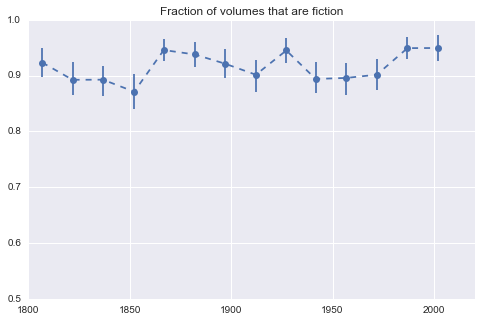

In [11]:
timeaxis = []
percentages = []
maxima = []
minima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & 
                        (all.firstpub < (decade + 15)), : ]
    ficvols = sum((in_decade.category == 'longfiction') | 
                  (in_decade.category == 'shortfiction') | 
                  (in_decade.category == 'juvenile'))
    nonficvols = sum((in_decade.category == 'notfiction')  | 
                     (in_decade.category == 'poetry') |
                    (in_decade.category == 'drama'))
    pct = ficvols / (ficvols + nonficvols)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    
    minimum, maximum = bootstrap_ratio(ficvols, nonficvols)
    maxima.append(maximum)
    minima.append(minimum)

plt.figure(figsize = (8,5))
# sns.set_style("darkgrid")
plt.xlim(1800,2020)
plt.ylim(0.5, 1)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o')
plt.title('Fraction of volumes that are fiction')
plt.show() 



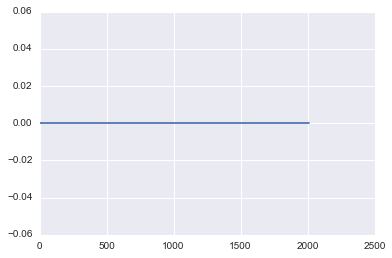

In [12]:
x = []
y = []

for year, df in all.groupby('firstpub'):
    x.append(year)
    y.append(len(df[df.category == 'novel'].firstpub))

plt.plot(x, y)

In [13]:
def isfiction(astring):
    ''' Note that this doesn't count juvenile fiction.
    '''
    
    if pd.isnull(astring):
        return 'not'

    if 'longfiction' in astring or 'shortfiction' in astring:
            return 'fic'
    else:
        return 'not'

all = all.assign(isfic = all.category.map(isfiction))

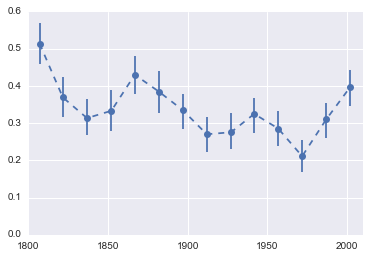

In [14]:
timeaxis = []
percentages = []
minima = []
maxima = []

for decade in range(1800, 2010, 15):
    in_decade = all.loc[(all.firstpub >= decade) & (all.firstpub < (decade + 15)) & ((all.isfic == 'fic')), : ]
    masculine = sum(in_decade.gender == 'm') 
    feminine = sum(in_decade.gender == 'f')
    pct = feminine / (masculine + feminine)
    timeaxis.append(np.mean(in_decade.firstpub))
    percentages.append(pct)
    minimum, maximum = bootstrap_ratio(feminine, masculine)
    maxima.append(maximum)
    minima.append(minimum)

plt.xlim(1800,2010)
plt.ylim(0.0, 0.6)
downward = np.array(percentages) - np.array(minima)
upward = np.array(maxima) - np.array(percentages)
plt.errorbar(timeaxis, percentages, yerr = [downward, upward], fmt='--o')
#plt.savefig('latestupdate.png')
plt.show() 
